In [8]:
import os
import pandas as pd
import geopandas as gpd

%cd {DIRECTORY}

DIRECTORY = r'C:\Users\nelms\Documents\Penn\MUSA-650\FinalProject'
DIR = DIRECTORY
PROJ_DIR = DIR
DATA_DIR = os.path.join(PROJ_DIR, 'data', 'raw', 'NAIP')
%cd {PROJ_DIR}

C:\Users\nelms\Documents\Penn\MUSA-650\FinalProject
C:\Users\nelms\Documents\Penn\MUSA-650\FinalProject


## Find Zips

In [3]:
zip_locations = [(root,dirnames,filenames) for root,dirnames,filenames in os.walk(DATA_DIR)][0][2]
zip_locations[0:5]

['m_3712212_se_10_060_20180804.ZIP',
 'm_3712212_se_10_060_20200524.ZIP',
 'm_3712212_se_10_1_20100611.ZIP',
 'm_3712212_se_10_1_20120520.ZIP',
 'm_3712212_se_10_1_20140613.ZIP']

## Downloading Zip as Temporary Bytes file

In [4]:
from skimage.io import imread, imshow
import rasterio as rio

tiff_proj = 'EPSG:26910'

In [5]:
import os
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
# or: requests.get(url).content

## https://github.com/phelber/eurosat#
#zip_location = r'https://madm.dfki.de/files/sentinel/EuroSAT.zip'
#zip_location = r'https://madm.dfki.de/files/sentinel/EuroSATallBands.zip'

#resp = urlopen(zip_location)
#zipfile = ZipFile(BytesIO(resp.read()))

In [9]:
from tqdm import tqdm

def spatial_resolution(raster):
    """extracts the XY Pixel Size"""
    t = raster.transform
    x = t[0]
    y =-t[4]
    return x, y

def get_raster_info(landsat):
    #landsat = rio.open(file_path)
    meta = landsat.meta
    proj = meta['crs'].data['init']
    bounds = [  # Set the extent of the images
        landsat.bounds.left,
        landsat.bounds.right,
        landsat.bounds.bottom,
        landsat.bounds.top,
    ]
    bands = landsat.indexes
    shape = landsat.shape
    resolution = spatial_resolution(landsat)
    
    return [landsat, proj, bounds, bands, shape, resolution, meta]

img_list = []

image_types = ['.tif'] #['.jpg', '.png', '.tif']
for zip_path in tqdm(zip_locations): #[zip_locations[0]]:
    full_zip_path = os.path.join(DATA_DIR, zip_path)
    with ZipFile(full_zip_path, mode="r") as zip_contents:
        for entry in zip_contents.infolist():
            if any(img for img in image_types if img in entry.filename):
                with zip_contents.open(entry) as file:
                    with rio.open(file) as dataset:
                        file_list = [entry.filename] + get_raster_info(dataset)
                        img_list.append(file_list)

cols = ['filename', 'raster', 'proj', 'bounds', 'bands', 'shape', 'resolution', 'meta']
img_df = pd.DataFrame(img_list, columns=cols)

 ... (more hidden) ...


In [33]:
img_df['date'] = img_df['filename'].str.split('_').apply(lambda dt: dt[-1].split('.')[0])
img_df['date'] = pd.to_datetime(img_df['date'])
img_df['year'] = img_df['date'].dt.year
img_df.head()

from shapely.geometry import box

def bound_to_poly(b_list):
    #ymin, ymax, xmin, xmax = b_list
    left, right, bottom, top = b_list
    width = right-left
    height = top-bottom
    b_list = [
        left,
        top,
        width,
        height
    ]
    return box(b_list[0], b_list[1], b_list[0] + b_list[2], b_list[1] - b_list[3]) #Polygon(zip(b_list))

img_df['bgeom'] = img_df['bounds'].apply(bound_to_poly)

<AxesSubplot:>

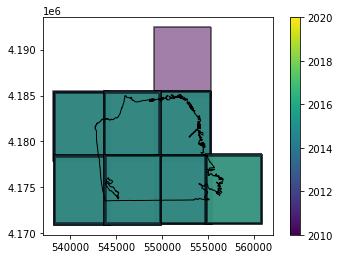

In [34]:
img_gdf = gpd.GeoDataFrame(img_df, crs=img_df['proj'].values[0], geometry = img_df['bgeom'])
ax = img_gdf.plot(alpha=.5, column='year', ec='black', lw=2, legend=True)
sf_landform.plot(ax=ax, zorder=8, color='None')

In [15]:
import geopandas as gpd

CAPSTONE_DATA_FOLDER = r'C:\Users\nelms\Documents\Penn\CPLN-680\Permit_Metrics\data'
#META_FOLDER = CAPSTONE_DATA_FOLDER + r'\meta'
#RAW_FOLDER = CAPSTONE_DATA_FOLDER + r'\raw'
CAPSTONE_CLEAN_FOLDER = CAPSTONE_DATA_FOLDER + r'\clean'

project_crs = 'EPSG:7132'

path = CAPSTONE_CLEAN_FOLDER + r'\sf_2010censusblock.geojson'
sfblock = gpd.read_file(path).to_crs(project_crs)

sftract = sfblock.dissolve(by='geoid10').reset_index(drop=False).drop('block_id', 1)

sf_landform = sfblock.unary_union
sf_landform = gpd.GeoDataFrame(geometry=[sf_landform], crs=project_crs).to_crs(tiff_proj)

C:\Users\nelms\AppData\Local\Temp\ipykernel_23472\2722954776.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  sftract = sfblock.dissolve(by='geoid10').reset_index(drop=False).drop('block_id', 1)


## Create Sub Folders

In [ ]:
image_types = ['.jpg', '.png', '.tif']
folders = [
           fname for fname in zipfile.namelist() if 
           #not any(ftype for ftype in image_types if ftype in fname)
           '.' not in fname
           ]
replacing = {
    'ds/images/remote_sensing/otherDatasets/sentinel_2':'',
    'tif':'MS'
}
#replacing = {
#    '2750':'RGB'
#}

def replace_list_dict(flist, sdict):
  for good,bad in sdict.items():
    flist = [f.replace(good,bad).strip('/') for f in flist]
  return flist

folders = replace_list_dict(folders, replacing)

os.chdir(PROJ_DIR)
print(os.getcwd())

def create_path(NEW_DIR, BASE_DIR=PROJ_DIR):
  os.chdir(BASE_DIR)
  if os.path.exists(NEW_DIR) == False:
    os.mkdir(NEW_DIR)

for folder in folders:
  create_path(folder) 
  print(folder)

/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat
MS
MS/PermanentCrop
MS/Industrial
MS/Highway
MS/HerbaceousVegetation
MS/Forest
MS/AnnualCrop
MS/Pasture
MS/Residential
MS/SeaLake
MS/River


## Prepare Files as Dict

In [ ]:
from tqdm import tqdm

def split_path_name(full_filename):
  filepath, filename = full_filename.rsplit('/', 1)
  return filepath, filename

replacing = {
    'ds/images/remote_sensing/otherDatasets/sentinel_2':'',
    'tif/':'MS/'
}
#replacing = {
#    '2750/':'RGB/'
#}


def replace_dict(rstr, sdict):
  for good,bad in sdict.items():
    rstr = rstr.strip('/').replace(good,bad)
  return rstr

def replace_list_dict(flist, sdict):
  for good,bad in sdict.items():
    flist = [f.strip('/').replace(good,bad) for f in flist]
  return flist



zip_info = zipfile.infolist()
#zip_info = zip_info[500:505]

zip_names = {}
for zfile in zip_info:
    full_filename = zfile.filename

    if '.' in full_filename:
        
      full_filename = replace_dict(full_filename, replacing)

      parts = full_filename.split('/')
      if '_' in parts[0]:
        new_sub = parts[0].split('_')[0]
        full_filename = new_sub + '/' + full_filename
        print(full_filename)
      fpath, fname = split_path_name(full_filename)
      if os.path.isfile(os.path.join(fpath,fname)) == False:
        if fpath not in zip_names.keys():
          zip_names[fpath] = []
        zfile.filename = fname
        zip_names[fpath].append({
              'name': fname,
              'path': fpath,
              'file': zfile
              })

## Upload Files by Subfolder

In [ ]:

os.chdir(PROJ_DIR)
%cd {PROJ_DIR}
errors = []
tried=[]

for dirname, filelist in zip_names.items():
  UPLOAD_DIR = os.path.join(PROJ_DIR, dirname)
  os.chdir(UPLOAD_DIR)
  %cd {UPLOAD_DIR}
  for fdict in tqdm(filelist, desc='{} '.format(dirname)):
    fname, fpath, zfile = fdict['name'], fdict['path'], fdict['file']
    try:
      
      zipfile.extract(zfile)
      #tried.append(UPLOAD_DIR+'/'+fname)
    except:
      errors.append(fname, UPLOAD_DIR)

/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat
/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat


MS/Pasture : 100%|██████████| 23/23 [00:00<00:00, 93.96it/s] 


/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat


MS/Residential : 100%|██████████| 3000/3000 [00:29<00:00, 102.74it/s]


/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat


MS/SeaLake : 100%|██████████| 3000/3000 [00:29<00:00, 102.80it/s]


/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat


MS/River : 100%|██████████| 2500/2500 [00:25<00:00, 99.71it/s]


In [ ]:
tried

['/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_1122.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_1685.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_1654.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_381.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_426.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_854.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_76.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_1592.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_1235.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_1770.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_970.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_502.tif',
 '/content/drive/MyDrive/Penn/MUSA-

## UPLOAD TO GOOGLE DRIVE

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()
drive = GoogleDrive(gauth)

# To create a new folder
folder_name = input("Name the Folder : ")
folder = drive.CreateFile({'title' : folder_name, 'mimeType' : 'application/vnd.google-apps.folder'})
folder.Upload()

Name the Folder : dog_test


InvalidConfigError: ignored